In [2]:
import math

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential

import numpy as np

from sklearn.calibration import calibration_curve
from sklearn import metrics

/home/andrew/Envs/calibration/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def ece(predictions, confidences, labels, n_bins=10, max_ece=False):
    # Get the different bins
    bins = np.linspace(0, 1, n_bins + 1)
    low_bins = bins[:-1]
    up_bins = bins[1:]
    all_bins = zip(low_bins, up_bins)
    
    num_samples = predictions.shape[0]
    ece_bin_values = []
    # For each bin work out the weighted difference between  
    # confidence and accuracy
    for low_bin, up_bin in all_bins:
        bin_conf_indcies = np.nonzero((confidences > low_bin) &
                                      (confidences <= up_bin))
        bin_confs = confidences[bin_conf_indcies]
        bin_preds = predictions[bin_conf_indcies]
        bin_labels = labels[bin_conf_indcies]
        
        num_samples_in_bin = bin_confs.shape[0]
        if num_samples_in_bin == 0:
            ece_bin_values.append(0)
            continue
        bin_weight = num_samples_in_bin / num_samples
        
        bin_acc = (bin_labels == bin_preds).mean()
        bin_mean_conf = bin_confs.mean()
        
        bin_acc_conf_diff = abs(bin_acc - bin_mean_conf)
        weighted_diff = bin_weight * bin_acc_conf_diff
        ece_bin_values.append(weighted_diff)
    # Return the max ece or the weighted average
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    if max_ece:
        return max(ece_bin_values)
    else:
        total_weighted_ece = sum(ece_bin_values)
        return total_weighted_ece

In [4]:
def adapt_ece(confidences, labels, samples_per_bin=250, root_error=False):
    label_conf = list(zip(labels, confidences))
    sorted_label_conf = sorted(label_conf, key=lambda x: x[1])
    num_samples = confidences.shape[0]
    bin_indexs = list(range(0, num_samples, samples_per_bin))
    # Merge the last bin with the second to last bin
    bin_indexs.append((num_samples + 1))
    low_bins = bin_indexs[:-1]
    up_bins = bin_indexs[1:]
    all_bins = list(zip(low_bins, up_bins))
    number_bins = len(all_bins)
    ece_bin_values = []
    for low_bin, up_bin in all_bins:
        bin_label_conf = sorted_label_conf[low_bin : up_bin]
        bin_label = np.array([label for label, conf in bin_label_conf])
        bin_conf = np.array([conf for label, conf in bin_label_conf])
        bin_size = bin_conf.shape[0]
        bin_mean_conf = bin_conf.mean()
        bin_mean_label = bin_label.mean()
        bin_mse = math.pow((bin_mean_conf - bin_mean_label), 2)
        bin_mse = bin_mse * bin_size
        ece_bin_values.append(bin_mse)
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    ece_error = sum(ece_bin_values) / num_samples
    if root_error:
        return math.sqrt(ece_error)
    else:
        return ece_error
    

In [5]:
ngram_range = 1
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,
                                                      seed=113)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(f'Average train sequence length: {np.mean(list(map(len, x_train)))}')
print(f'Average test sequence length: {np.mean(list(map(len, x_test)))}')

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238.71364
Average test sequence length: 230.8042


In [12]:
# This makes all of the sequences the same size
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [13]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(layers.Embedding(max_features,
                           embedding_dims,
                           input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(layers.GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
train_eces = []
train_max_eces = []
train_accs = []
train_briers = []
train_cross_entropys = []
train_abs_calibration = []
train_mse_calibration = []
train_adapt_eces = []
train_adapt_rmse_eces = []



val_eces = []
val_max_eces = []
val_accs = []
valid_briers = []
val_cross_entropys = []
valid_abs_calibration = []
valid_mse_calibration = []
val_adapt_eces = []
val_adapt_rmse_eces = []


for j in range(1, 50):
    print(f'epoch {j}')
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(x_test, y_test))
    
    preds_train = model.predict(x_train)
    preds_val = model.predict(x_test)
    
    conf_train = preds_train.max(axis=1)
    conf_val = preds_val.max(axis=1)
    
    preds_train_labels = np.round(preds_train).reshape(preds_train.shape[0],)
    preds_val_labels = np.round(preds_val).reshape(preds_val.shape[0],)

    
    train_ece = ece(preds_train_labels, conf_train, y_train, n_bins=15)
    train_eces.append(train_ece)
    train_max_ece = ece(preds_train_labels, conf_train, y_train, max_ece=True, n_bins=15)
    train_max_eces.append(train_max_ece)
    train_adapt_ece = adapt_ece(conf_train, y_train)
    train_adapt_eces.append(train_adapt_ece)
    train_adapt_rmse_ece = adapt_ece(conf_train, y_train, root_error=True)
    train_adapt_rmse_eces.append(train_adapt_rmse_ece)
    train_cat_acc = metrics.accuracy_score(y_train, preds_train_labels)
    train_accs.append(train_cat_acc)
    train_cross_entropy = metrics.log_loss(y_train, preds_train)
    train_cross_entropys.append(train_cross_entropy)
    train_brier = metrics.brier_score_loss(y_train, preds_train)
    train_briers.append(train_brier)
    
    train_empirical_probs, train_predicted_probs= calibration_curve(y_train , conf_train,n_bins=15)
    train_abs_cal = abs(train_empirical_probs - train_predicted_probs).mean()
    train_mse_cal = ((train_empirical_probs - train_predicted_probs)**2).mean()
    train_abs_calibration.append(train_abs_cal)
    train_mse_calibration.append(train_mse_cal)
    print(f'Train: ece {train_ece:.2f} max ece {train_max_ece:.2f} acc '
          f'{train_cat_acc:.2f} entropy {train_cross_entropy:.2f} '
          f'brier {train_brier:.2f} adapt {train_adapt_ece:.2f} '
          f'cal abs {train_abs_cal:.2f} cal mse {train_mse_cal:.2f}')
    
    val_ece = ece(preds_val_labels, conf_val, y_test, n_bins=15)
    val_eces.append(val_ece)
    val_max_ece = ece(preds_val_labels, conf_val, y_test, max_ece=True, n_bins=15)
    val_max_eces.append(val_max_ece)
    val_adapt_ece = adapt_ece(conf_val, y_test)
    val_adapt_eces.append(val_adapt_ece)
    val_adapt_rmse_ece = adapt_ece(conf_val, y_test, root_error=True)
    val_adapt_rmse_eces.append(val_adapt_rmse_ece)
    val_cat_acc = metrics.accuracy_score(y_test, preds_val_labels)
    val_accs.append(val_cat_acc)
    val_cross_entropy = metrics.log_loss(y_test, preds_val)
    val_cross_entropys.append(val_cross_entropy)
    valid_brier = metrics.brier_score_loss(y_test, preds_val)
    valid_briers.append(valid_brier)
    
    valid_empirical_probs, valid_predicted_probs= calibration_curve(y_test , conf_val,n_bins=15)
    val_abs_cal = abs(valid_empirical_probs - valid_predicted_probs).mean()
    val_mse_cal = ((valid_empirical_probs-valid_predicted_probs)**2).mean()
    valid_abs_calibration.append(val_abs_cal)
    valid_mse_calibration.append(val_mse_cal)
    print(f'Val: ece {val_ece:.2f} max ece {val_max_ece:.2f} '
          f'acc {val_cat_acc:.2f} entropy {val_cross_entropy:.2f} '
          f'brier {valid_brier:.2f} adapt {val_adapt_ece:.2f} '
          f'cal abs {val_abs_cal:.2f} cal mse {val_mse_cal:.2f}')

epoch 1
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 36s 1ms/step - loss: 0.6689 - acc: 0.6694 - val_loss: 0.6395 - val_acc: 0.7770
0.00 0.00 0.00 0.00 0.00 0.02 0.11 0.09 0.07 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.02 0.11 0.09 0.07 0.01 0.00 0.00 0.00 0.00 0.00
22.54 28.19 28.86 30.72 26.09 29.16 30.11 33.04 32.32 34.42 26.69 30.66 30.43 32.31 27.23 25.64 27.29 29.00 27.98 20.26 24.73 21.99 18.84 18.01 19.34 17.94 13.17 15.28 20.27 13.73 19.03 15.05 15.72 7.07 5.30 7.66 9.25 9.00 8.01 6.10 9.36 5.69 4.90 3.44 0.09 3.36 0.71 0.17 0.57 0.04 0.02 0.00 0.06 0.12 0.11 0.32 4.26 3.68 0.58 3.53 3.00 5.81 6.33 6.88 7.11 10.35 15.66 19.19 12.08 18.30 21.51 17.95 27.34 25.17 28.21 35.06 22.64 27.45 23.40 36.95 31.48 28.44 30.89 29.18 31.63 31.27 35.22 37.08 38.14 36.87 32.62 32.76 36.58 39.67 35.60 42.17 39.17 35.79 38.00 33.83
22.54 28.19 28.86 30.72 26.09 29.16 30.11 33.04 32.32 34.42 26.69 30.66 30.43 32.31 27.2

25000/25000 [==============================] - 36s 1ms/step - loss: 0.4184 - acc: 0.8635 - val_loss: 0.4166 - val_acc: 0.8506
0.05 0.07 0.07 0.06 0.04 0.03 0.01 0.00 0.02 0.02 0.02 0.01 0.01 0.00 0.00
0.05 0.07 0.07 0.06 0.04 0.03 0.01 0.00 0.02 0.02 0.02 0.01 0.01 0.00 0.00
0.01 0.09 0.19 0.24 0.34 0.54 0.89 1.05 0.95 1.53 2.46 2.48 2.49 3.33 3.07 3.78 4.31 4.58 6.05 3.86 4.39 4.10 6.69 4.86 6.39 5.48 9.22 5.23 10.14 5.94 6.60 5.92 8.69 8.38 8.44 6.15 5.89 11.91 5.13 3.84 3.40 3.49 2.28 2.98 2.66 0.16 0.10 0.01 0.00 0.20 0.05 0.89 0.94 2.46 5.21 4.72 10.33 9.05 6.48 14.79 12.29 14.34 13.69 12.68 15.99 18.54 18.44 17.84 18.89 15.65 19.80 17.00 16.39 15.27 16.10 12.18 14.94 14.87 11.55 11.37 12.10 11.06 10.15 8.52 9.90 8.24 6.33 8.92 7.15 5.59 5.70 4.38 3.84 3.51 2.97 2.09 1.14 0.72 0.47 0.12
0.01 0.09 0.19 0.24 0.34 0.54 0.89 1.05 0.95 1.53 2.46 2.48 2.49 3.33 3.07 3.78 4.31 4.58 6.05 3.86 4.39 4.10 6.69 4.86 6.39 5.48 9.22 5.23 10.14 5.94 6.60 5.92 8.69 8.38 8.44 6.15 5.89 11.91 5.13 

25000/25000 [==============================] - 35s 1ms/step - loss: 0.2905 - acc: 0.9015 - val_loss: 0.3277 - val_acc: 0.8764
0.17 0.08 0.05 0.04 0.02 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.00
0.17 0.08 0.05 0.04 0.02 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.06 0.06 0.19 0.07 0.26 0.28 0.29 0.40 0.43 0.48 0.73 0.80 0.89 0.85 1.51 1.32 1.59 1.44 2.15 3.25 2.29 3.01 3.60 3.72 2.92 2.25 4.49 4.01 3.10 6.69 4.17 2.91 6.33 6.27 4.30 2.41 1.98 1.95 2.11 0.10 0.02 1.33 1.48 0.03 2.66 0.86 6.29 5.18 4.06 7.61 8.86 9.99 8.12 7.08 10.08 8.36 9.00 8.57 7.50 8.51 5.30 7.49 5.93 6.36 3.90 3.76 3.22 1.76 4.29 3.52 2.01 3.00 1.83 2.17 1.64 1.23 1.00 1.15 0.91 0.84 0.40 0.44 0.39 0.35 0.15 0.09 0.05 0.08 0.02 0.02 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.06 0.06 0.19 0.07 0.26 0.28 0.29 0.40 0.43 0.48 0.73 0.80 0.89 0.85 1.51 1.32 1.59 1.44 2.15 3.25 2.29 3.01 3.60 3.72 2.92 2.25 4.49 4.01 3.10 6.69 4.17 2.91 6.33 6.27 4.30 2.41 1.9

0.20 0.07 0.04 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00
0.20 0.07 0.04 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.08 0.07 0.04 0.10 0.11 0.28 0.12 0.32 0.35 0.89 0.44 0.82 0.91 1.17 0.82 1.51 1.91 2.59 2.57 2.34 3.89 3.40 5.87 6.02 6.50 7.85 8.22 5.84 9.65 7.66 9.89 9.72 8.80 7.50 9.34 14.43 10.87 3.65 6.11 3.21 0.00 0.69 0.02 0.45 1.51 0.35 0.86 1.04 1.11 2.83 1.86 1.77 2.09 2.44 1.77 2.64 1.47 0.88 1.00 1.73 0.88 0.78 0.61 1.12 0.71 0.68 0.18 0.52 0.42 0.34 0.26 0.33 0.07 0.11 0.16 0.08 0.09 0.07 0.08 0.03 0.02 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.08 0.07 0.04 0.10 0.11 0.28 0.12 0.32 0.35 0.89 0.44 0.82 0.91 1.17 0.82 1.51 1.91 2.59 2.57 2.34 3.89 3.40 5.87 6.02 6.50 7.85 8.22 5.84 9.65 7.66 9.89 9.72 8.80 7.50 9.34 14.43 10.87 3.65 6.11 3.21 0.00 0.69 0.02 0.45 1.51 0.35 0.86 1.04 1.11 2.83 1.86 1.77 2.09 2.44 1.77 2.64 1.47 0.88 1.00 1

/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


25000/25000 [==============================] - 35s 1ms/step - loss: 0.2088 - acc: 0.9295 - val_loss: 0.2862 - val_acc: 0.8877
0.26 0.07 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
0.26 0.07 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.03 0.05 0.02 0.03 0.04 0.00 0.19 0.03 0.14 0.24 0.25 0.33 0.29 0.48 0.74 0.82 1.03 0.76 0.89 0.79 0.84 1.44 1.86 3.02 3.12 3.95 2.58 2.61 2.27 4.85 3.52 3.52 5.23 4.08 2.02 2.21 0.24 0.04 0.83 1.67 4.43 6.05 1.51 2.95 8.50 6.11 4.77 7.25 4.26 5.30 4.72 5.48 2.60 2.52 3.33 1.89 2.13 2.23 1.18 1.62 1.65 1.23 1.11 0.78 0.52 0.57 0.54 0.27 0.26 0.14 0.32 0.19 0.10 0.11 0.07 0.08 0.00 0.02 0.00 0.02 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.03 0.05 0.02 0.03 0.04 0.00 0.19 0.03 0.14 0.24 0.25 0.33 0.29 0.48 0.74 0.82 1.03 0.76 0.89 0.79 0.84 1.44 1.86 3.02 3.12 3.95 2.58 2.61 2.27 4.85 3.52 3.52 5.23

0.28 0.06 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00
0.28 0.06 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.03 0.01 0.02 0.01 0.07 0.10 0.03 0.06 0.19 0.26 0.28 0.25 0.51 0.67 0.75 1.39 1.00 1.46 0.87 0.62 1.82 2.43 2.94 3.68 4.36 5.83 5.60 2.70 4.66 5.42 5.34 6.49 11.55 0.99 0.01 0.03 0.40 0.62 1.61 2.69 3.48 2.76 5.00 4.93 4.08 2.62 3.25 2.72 3.12 2.31 1.81 1.25 1.10 0.93 0.93 1.38 0.41 0.86 0.51 0.48 0.46 0.37 0.23 0.09 0.13 0.10 0.02 0.05 0.09 0.07 0.05 0.02 0.03 0.02 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.03 0.01 0.02 0.01 0.07 0.10 0.03 0.06 0.19 0.26 0.28 0.25 0.51 0.67 0.75 1.39 1.00 1.46 0.87 0.62 1.82 2.43 2.94 3.68 4.36 5.83 5.60 2.70 4.66 5.42 5.34 6.49 11.55 0.99 0.01 0.03 0.40 0.62 1.61 2.69 3.48 2.76 5.00 4.93 4.08 2.62 3.25 2.72 3.12 2.31 1.81 1.25 1.10 0.93 0.9

25000/25000 [==============================] - 35s 1ms/step - loss: 0.1497 - acc: 0.9531 - val_loss: 0.2765 - val_acc: 0.8911
0.31 0.06 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.31 0.06 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.02 0.03 0.02 0.01 0.00 0.00 0.02 0.11 0.07 0.20 0.11 0.28 0.25 0.72 0.68 1.02 1.44 1.03 1.08 1.82 2.36 2.62 1.53 3.59 4.50 4.69 4.35 4.94 5.95 6.01 6.33 9.34 2.85 3.38 0.05 0.38 0.92 3.39 4.26 3.68 5.53 3.22 3.70 4.10 2.28 1.64 1.05 1.48 1.08 1.18 1.33 1.07 0.73 0.32 0.37 0.28 0.27 0.26 0.15 0.07 0.12 0.01 0.10 0.02 0.01 0.05 0.03 0.03 0.02 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.02 0.03 0.02 0.01 0.00 0.00 0.02 0.11 0.07 0.20 0.11 0.28 0.25 0.72 0.68 1.02 1.44 1.03 1.08 1.82 2.36 2.62 1.53 3.59 4.50 4.69 4.35 4.94 5.95

0.32 0.05 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.32 0.05 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.02 0.03 0.04 0.01 0.02 0.03 0.05 0.01 0.05 0.30 0.15 0.43 0.25 0.64 1.11 0.98 1.77 1.92 2.08 2.11 3.31 3.36 4.22 4.28 5.19 5.83 10.40 6.27 9.07 11.89 5.60 6.55 0.89 0.66 0.87 4.25 2.39 4.40 2.86 3.25 1.96 1.50 0.89 1.59 1.33 1.00 0.45 0.99 0.69 0.45 0.21 0.15 0.20 0.15 0.21 0.12 0.03 0.04 0.08 0.06 0.02 0.00 0.03 0.02 0.01 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.02 0.03 0.04 0.01 0.02 0.03 0.05 0.01 0.05 0.30 0.15 0.43 0.25 0.64 1.11 0.98 1.77 1.92 2.08 2.11 3.31 3.36 4.22 4.28 5.19 5.83 10.40 6.27 9.07 11.89 5.60 6.55 0.89 0.66 0.87 4.25 2.39 4.40 2.86 3.25 1.96 1.50 0.89 1.59 1.33 1.00 0.45 0.99 0.69 0.45 0.21 0

25000/25000 [==============================] - 35s 1ms/step - loss: 0.1112 - acc: 0.9678 - val_loss: 0.2896 - val_acc: 0.8876
0.35 0.05 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.35 0.05 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.01 0.03 0.05 0.02 0.04 0.11 0.21 0.18 0.20 0.46 0.52 0.82 0.85 1.50 2.01 2.42 2.37 3.28 3.18 5.71 3.65 6.75 8.64 6.74 6.53 2.78 0.07 2.20 4.08 4.64 3.00 4.64 2.92 2.70 1.91 2.49 2.06 1.28 1.32 1.11 0.74 0.56 0.42 0.31 0.23 0.23 0.23 0.09 0.04 0.07 0.09 0.07 0.05 0.02 0.03 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.01 0.03 0.05 0.02 0.04 0.11 0.21 0.18 0.20 0.46 0.52 0.82 0.85 1.50 2.01 2.42 2.37 3.28 3.18 5.71 3.65

0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.02 0.03 0.02 0.03 0.02 0.11 0.10 0.15 0.16 0.13 0.28 0.50 0.77 1.00 1.35 1.20 1.85 2.73 3.85 4.32 6.32 5.66 7.44 10.84 13.35 13.44 12.12 2.90 0.67 0.36 0.87 4.08 1.53 1.22 1.98 2.21 1.48 0.71 1.01 0.99 0.65 0.39 0.22 0.26 0.20 0.07 0.07 0.08 0.06 0.07 0.03 0.04 0.01 0.02 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.02 0.03 0.02 0.03 0.02 0.11 0.10 0.15 0.16 0.13 0.28 0.50 0.77 1.00 1.35 1.20 1.85 2.73 3.85 4.32 6.32 5.66 7.44 10.84 13.35 13.44 12.12 2.90 0.67 0.36 0.87 4.08 1.53 1.22 1.98 2.21 1.48 0.71 1.01 0.99 0.65 0.39 0.22 0.26 0.20 0.07 0.

25000/25000 [==============================] - 35s 1ms/step - loss: 0.0835 - acc: 0.9781 - val_loss: 0.3141 - val_acc: 0.8822
0.37 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.37 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.02 0.03 0.00 0.05 0.07 0.07 0.02 0.20 0.28 0.18 0.34 0.48 0.67 1.06 1.44 1.61 2.77 2.81 3.44 5.21 7.11 9.69 8.84 14.35 10.03 3.81 0.02 0.23 3.97 2.58 2.12 2.81 1.84 1.90 1.00 0.93 0.69 0.51 0.28 0.39 0.23 0.12 0.05 0.13 0.06 0.07 0.03 0.04 0.03 0.02 0.02 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.02 0.03 0.00 0.05 0.07 0.07 0.02 0.20 0.28 0.18 0.34 0.48 0.67 1.06 1.44 1.61 2.77 2.81 3.44 5.21 7.

0.41 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.41 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.04 0.01 0.02 0.11 0.07 0.10 0.15 0.29 0.41 0.67 0.39 1.09 1.23 1.62 2.75 2.57 3.92 5.20 4.16 0.02 2.92 8.30 11.10 5.63 7.84 5.70 3.54 2.67 2.65 1.36 1.56 0.91 0.88 0.65 0.26 0.29 0.21 0.21 0.11 0.12 0.09 0.07 0.05 0.04 0.00 0.00 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.02 0.01 0.04 0.01 0.02 0.11 0.07 0.10 0.15 0.29 0.41 0.67 0.39 1.09 1.23 1.62 2.75 2.57 3.92 5.20 4.16 0.02 2.92 8.30 11.10 5.63 7.84 5.70 3.54 2.67 2.65 1.36 1.56 0.91 0.88 0.65 0.26 0.29 0.21 0.21 0.11 0.1

25000/25000 [==============================] - 35s 1ms/step - loss: 0.0626 - acc: 0.9851 - val_loss: 0.3462 - val_acc: 0.8779
0.39 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.39 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.05 0.07 0.10 0.10 0.07 0.27 0.24 0.53 0.61 0.65 1.19 1.64 2.09 2.63 4.47 5.07 9.20 10.45 15.79 3.79 0.09 2.23 3.21 2.91 2.81 1.41 1.15 1.00 0.82 0.62 0.38 0.27 0.14 0.18 0.06 0.06 0.07 0.05 0.04 0.03 0.01 0.02 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.05 0.07 0.10 0.10 0.07 0.27 0.24 0.53 0.61 0.65 1.19 1.64 2.09 2.63 4.

0.40 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.40 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.02 0.03 0.02 0.02 0.09 0.13 0.18 0.14 0.16 0.41 0.68 0.82 1.14 1.29 2.35 2.90 4.01 6.10 7.45 13.97 18.36 8.83 0.00 3.26 1.83 2.21 1.20 1.21 0.94 0.65 0.38 0.27 0.26 0.10 0.06 0.06 0.07 0.05 0.04 0.01 0.02 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.02 0.03 0.02 0.02 0.09 0.13 0.18 0.14 0.16 0.41 0.68 0.82 1.14 1.29 2.35 2.90 4.01 6.10 7.45 13.97 18.36 8.83 0.00 3.26 1.83 2.21 1.20 1.21 0.94 0.65 0.38 0.27 0.26 0.10 0.06 0.06 0.07 0.05 0.04 0.01 0.02 0

25000/25000 [==============================] - 35s 1ms/step - loss: 0.0465 - acc: 0.9902 - val_loss: 0.3847 - val_acc: 0.8726
0.43 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.43 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.01 0.01 0.05 0.07 0.06 0.10 0.10 0.28 0.24 0.52 0.51 1.01 0.71 2.06 3.08 3.57 6.92 2.62 5.48 8.79 7.16 4.08 3.23 1.96 1.32 0.88 0.62 0.36 0.31 0.28 0.15 0.14 0.10 0.07 0.03 0.02 0.03 0.02 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.01 0.01 0.05 0.07 0.06 0.10 0.10 0.28 0.24 0.52 0.51 1.01 0.71

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Accuracy

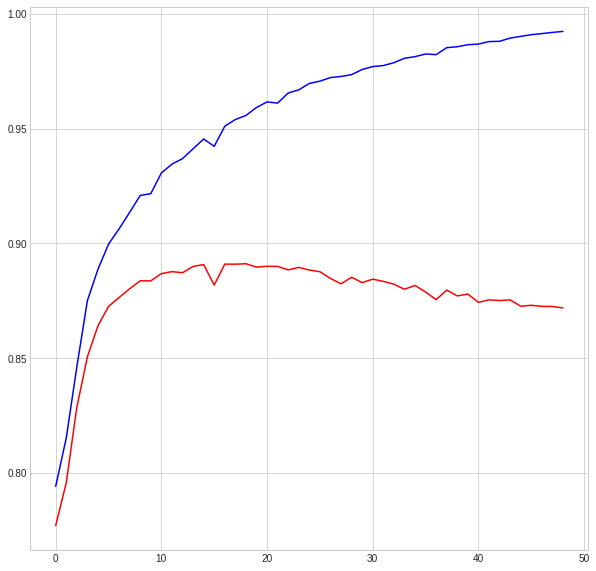

In [17]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_accs, 'b')
plt.plot(val_accs, 'r')
plt.savefig('accuracy.png', dpi = 300)

In [18]:
np.array(val_accs).argmax()

18

In [40]:
val_accs[18]

0.89112

In [41]:
val_accs[47]

0.87248

In [42]:
val_accs[21]

0.88996

# Brier score

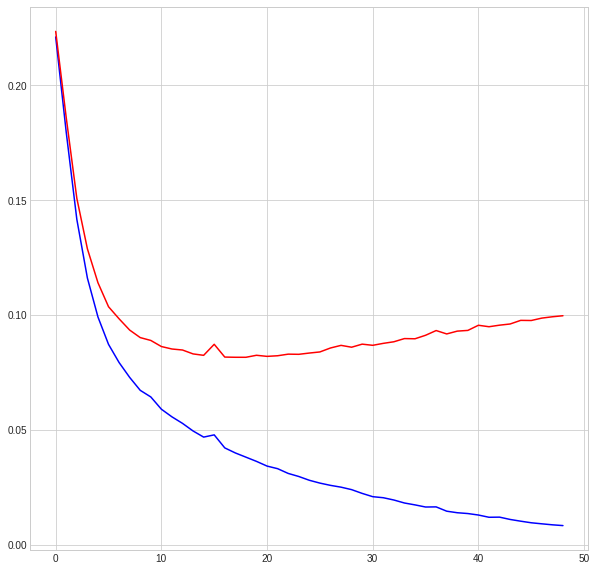

In [21]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_briers, 'b')
plt.plot(valid_briers, 'r')
plt.savefig('Briers.png', dpi = 300)

In [38]:
np.argmin(train_briers)

48

In [39]:
np.argmin(valid_briers)

18

# Cross Entropy

Got NAN values after 10 epochs

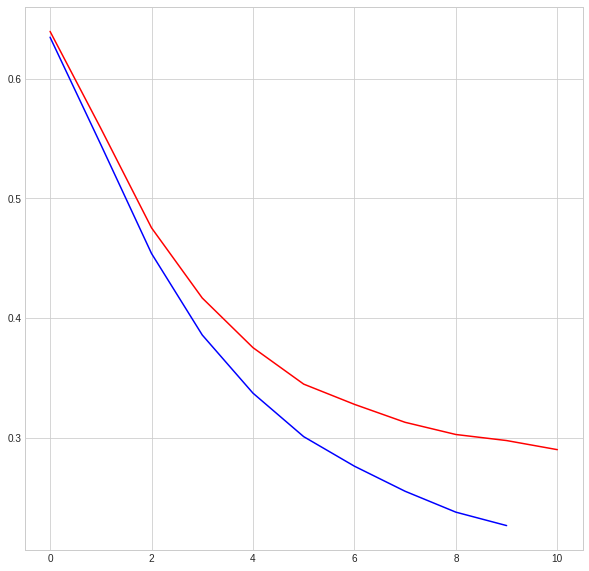

In [22]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_cross_entropys, 'b')
plt.plot(val_cross_entropys, 'r')
plt.savefig('cross entropy.png', dpi = 300)

# Adapted ECE

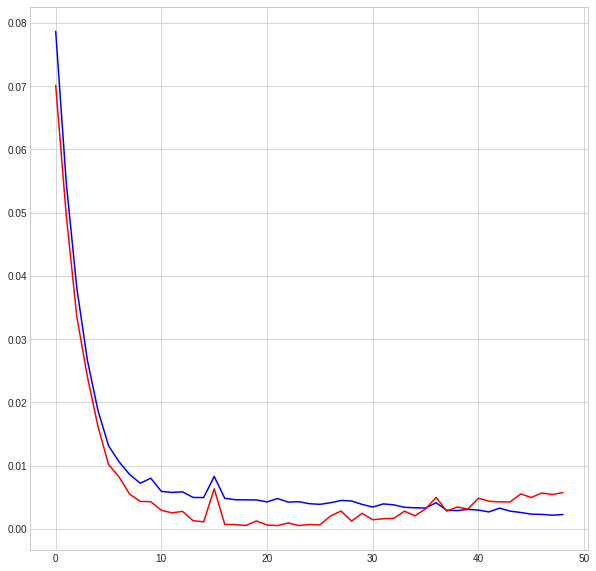

In [23]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_adapt_eces, 'b')
plt.plot(val_adapt_eces, 'r')
plt.savefig('Adapted ECE.png', dpi = 300)

In [36]:
np.argmin(train_adapt_eces)

47

In [35]:
np.argmin(val_adapt_eces)

21

# RMSE adapted ECE

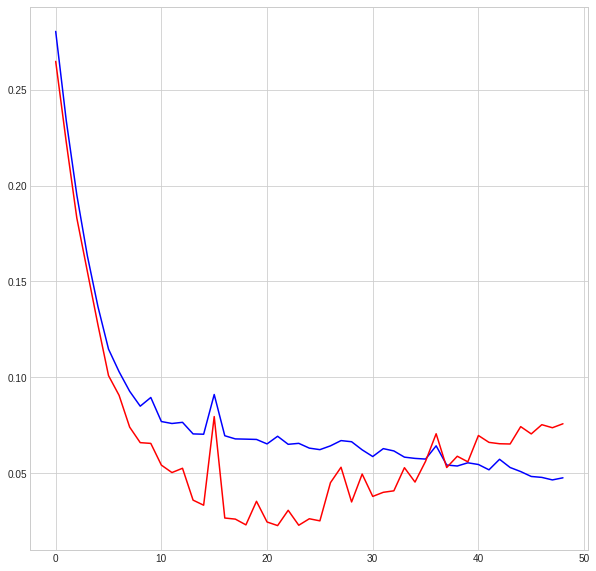

In [24]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_adapt_rmse_eces, 'b')
plt.plot(val_adapt_rmse_eces, 'r')
plt.savefig('RMSE Adapted ECE.png', dpi = 300)

In [33]:
np.argmin(train_adapt_rmse_eces)

47

In [34]:
np.argmin(val_adapt_rmse_eces)

21

# ECE

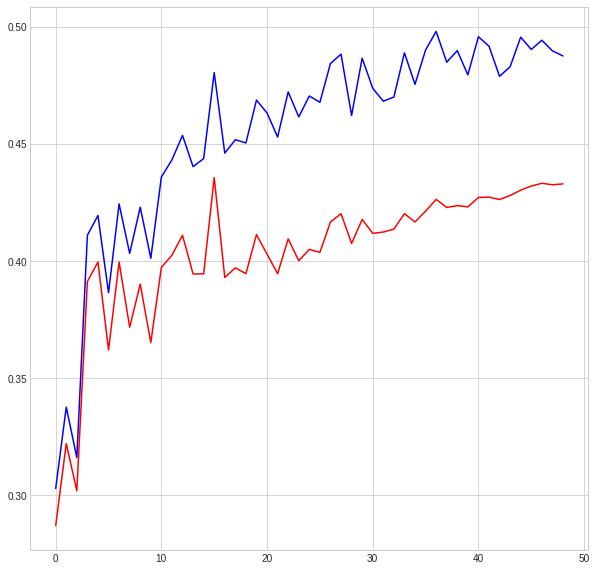

In [25]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_eces, 'b')
plt.plot(val_eces, 'r')
plt.savefig('ece.png', dpi = 300)

# Absolute Calibration

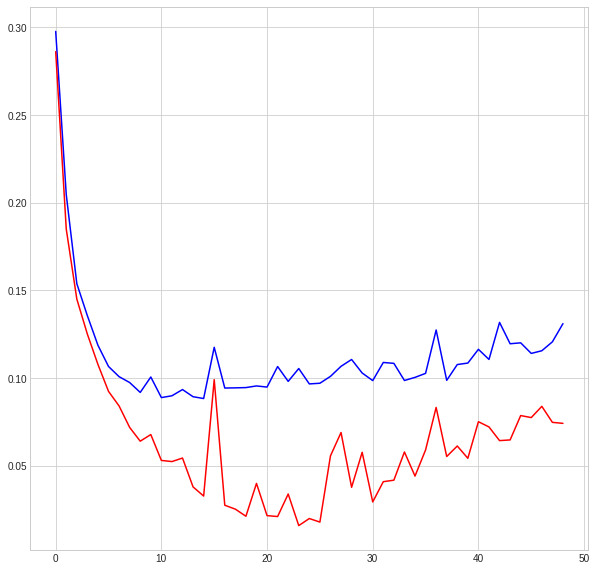

In [26]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_abs_calibration, 'b')
plt.plot(valid_abs_calibration, 'r')
plt.savefig('Absolute Calibration.png', dpi = 300)

In [27]:
np.array(valid_abs_calibration).argmin()

23

In [28]:
np.array(train_abs_calibration).argmin()

14

# MCE

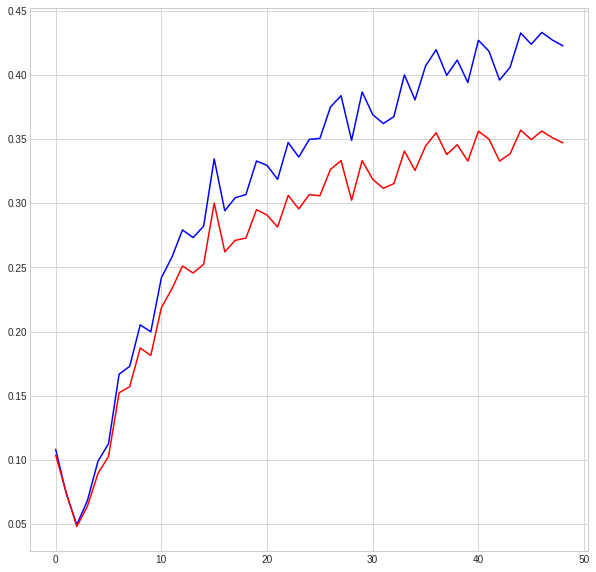

In [29]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_max_eces, 'b')
plt.plot(val_max_eces, 'r')
plt.savefig('mce.png', dpi = 300)

# MSE Calibration

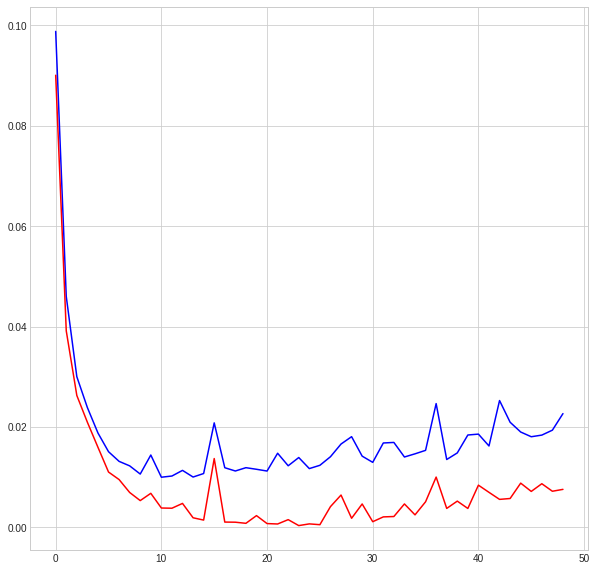

In [30]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_mse_calibration, 'b')
plt.plot(valid_mse_calibration, 'r')
plt.savefig('MSE Calibration.png', dpi = 300)

In [31]:
np.array(valid_abs_calibration).argmin()

23

In [32]:
np.array(train_abs_calibration).argmin()

14